In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [5]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [92]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 32

In [97]:
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [8,16]

In [98]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        strides=2,
        padding='same')(x)

In [99]:
pic = x_train[0].reshape(28,28)


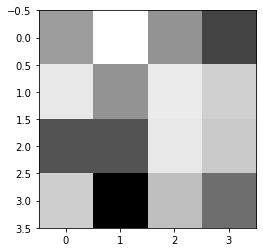

In [129]:
plt.imshow(encoder.predict(pic.reshape(1,28,28,1)).reshape(4,4), cmap='gray')

In [101]:
shape = K.int_shape(x)

In [102]:
x = Flatten()(x)

In [103]:
latent = Dense(latent_dim, name='latent_vector')(x)

In [104]:
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 8)         80        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                12560     
Total params: 13,808
Trainable params: 13,808
Non-trainable params: 0
_________________________________________________________________


In [105]:
# build the decoder model
latent_inputs = Input(
    shape=(latent_dim,), 
    name='decoder_input')

In [106]:
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

In [107]:
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [108]:
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
        kernel_size=kernel_size,        
        activation='relu',
        strides=2,
        padding='same')(x)

In [109]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
            kernel_size=kernel_size,
            activation='sigmoid',
            padding='same',
            name='decoder_output')(x)

In [110]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 8)         80        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                12560     
Total params: 13,808
Trainable params: 13,808
Non-trainable params: 0
_________________________________________________________________


In [111]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               13328     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 16)        2320      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 8)         1160      
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         73        
Total params: 16,881
Trainable params: 16,881
Non-trainable params: 0
_______________________________________________________

In [112]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
            decoder(encoder(inputs)),
            name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                13808     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         16881     
Total params: 30,689
Trainable params: 30,689
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [114]:
# train the autoencoder
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=1,
                batch_size=batch_size)


1875/1875 [==============================] - 65s 34ms/step - loss: 0.0570 - val_loss: 0.0142


In [42]:
#predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

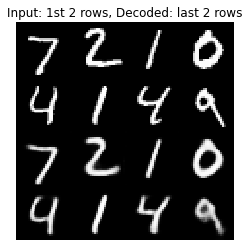

In [76]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

In [121]:
def plot_results(models, data, batch_size=32, model_name="autoencoder_2dim"):
    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
#     os.makedirs(model_name, exist_ok=True)
#     filename = os.path.join(model_name, "latent_2dim.png")
    z = encoder.predict(x_test,
                        batch_size=batch_size)
#     plt.figure(figsize=(12, 10))
    # axes x and y ranges
    display(z.shape)
#     axes = plt.gca()
#     axes.set_xlim([xmin,xmax])
#     axes.set_ylim([ymin,ymax])
    # subsample to reduce density of points on the plot
    z = z[0::2]
#     display(z.shape)
    y_test = y_test[0::2]
#     display(z[:, 0])
#     plt.scatter(z[:, 0], z[:, 1], marker="")
#     for i, digit in enumerate(y_test[:10]):
#         axes.annotate(digit, (z[i, 0], z[i, 1]))
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.savefig(filename)
#     plt.show()

    
    

In [125]:
plot_results(models=(encoder, decoder), data=(x_train, x_test))

(60000, 16)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000023535B73EE8> (for post_execute):


KeyboardInterrupt: 